In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib
import random
import sys, os

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10, ImageNet
from torchvision import transforms

# Setup and Data Download

In [2]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Connected to GPU")
else:
  raise ValueError("No GPU available")

Connected to GPU


In [3]:
!nvidia-smi

Fri Dec  2 11:13:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Create fake image batch using random image generation
image_size = (1, 3, 256,256)
image = torch.rand(image_size)
image = image.to(device)

In [5]:
models = []
model_names = ["VGG11", "VGG11 (batch norm)", "ResNet18", "ResNet34", "DenseNet121", "MobileNet-v3-Small"]
model_accuracies = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]
parameter_num = [132.9e6,132.9e6,11.7e6,21.8e6,8.0e6,2.5e6]
parameter_num_million = [132.9,132.9,11.7,21.8,8.0,2.5]

model_inference_runtime = []
model_inference_runtime_grads = []

# Initialize models with pretrained parameters


# Initialization and Evaluation of Models

In [6]:
from torchvision.models import vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small

models = [vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small]
models = [m(weights="IMAGENET1K_V1").to(device) for m in models]
#models = [m(weights="IMAGENET1K_V1") for m in models]

# Exercise 1.1a)

In [7]:
num_warmup = 100
num_iterations = 1000
model_inference_runtime = []
model_inference_runtime_grads = []

for idx, model in enumerate(models):
  model.eval()
  # no grad version
  with torch.no_grad():
    for i in range(num_warmup + num_iterations):
      if i == num_warmup:
        start = time()
      _ = model(image)
  end = time()
  duration = (end - start) / num_iterations * 1000
  model_inference_runtime.append(duration)
  print(f"Model {model_names[idx]} took an average of {round(duration, 2)}ms per image")
  # grad version
  for i in range(num_warmup + num_iterations):
    if i == num_warmup:
      start = time()
    _ = model(image)
  end = time()
  duration = (end - start) / num_iterations * 1000
  model_inference_runtime_grads.append(duration)
  print(f"Model {model_names[idx]} took an average of {round(duration, 2)}ms per image (with gradient determination)")

Model VGG11 took an average of 7.62ms per image
Model VGG11 took an average of 7.66ms per image (with gradient determination)
Model VGG11 (batch norm) took an average of 8.04ms per image
Model VGG11 (batch norm) took an average of 8.11ms per image (with gradient determination)
Model ResNet18 took an average of 4.05ms per image
Model ResNet18 took an average of 4.3ms per image (with gradient determination)
Model ResNet34 took an average of 7.73ms per image
Model ResNet34 took an average of 7.77ms per image (with gradient determination)
Model DenseNet121 took an average of 19.71ms per image
Model DenseNet121 took an average of 21.78ms per image (with gradient determination)
Model MobileNet-v3-Small took an average of 6.77ms per image
Model MobileNet-v3-Small took an average of 7.78ms per image (with gradient determination)


#### Top-1 accuracy on ImageNet vs the inference speed

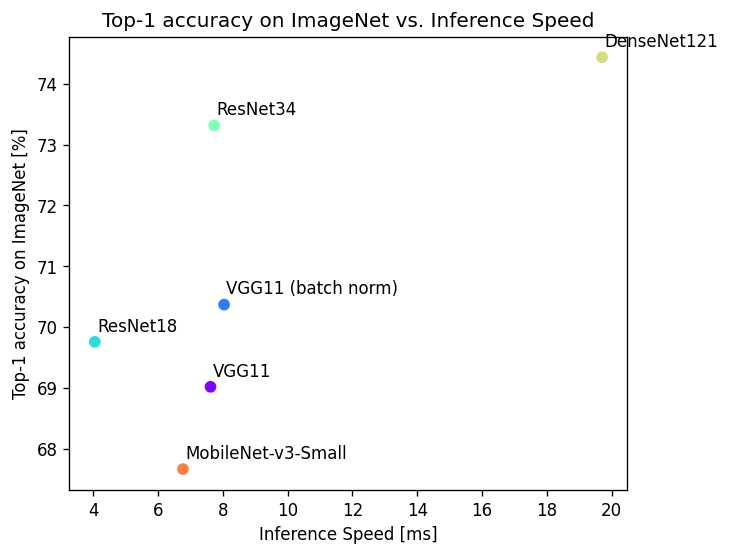

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)


cm = matplotlib.cm.rainbow(np.arange(len(model_names)) / len(model_names))
#ax.scatter(model_accuracies, model_inference_runtime, c=cm)
ax.scatter(model_inference_runtime, model_accuracies, c=cm)

for i, model_name in enumerate(model_names):
  #ax.scatter(model_accuracies[i], model_inference_runtime[i], label=model_name)
  x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
  y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
  #ax.annotate(model_name, (model_accuracies[i] + x_offset, model_inference_runtime[i] + y_offset))
  ax.annotate(model_name, (model_inference_runtime[i] + y_offset, model_accuracies[i] + x_offset))

plt.title("Top-1 accuracy on ImageNet vs. Inference Speed")
ax.set_ylabel("Top-1 accuracy on ImageNet [%]")
ax.set_xlabel("Inference Speed [ms]")

plt.show()

#### Inference speed vs the number of parameters

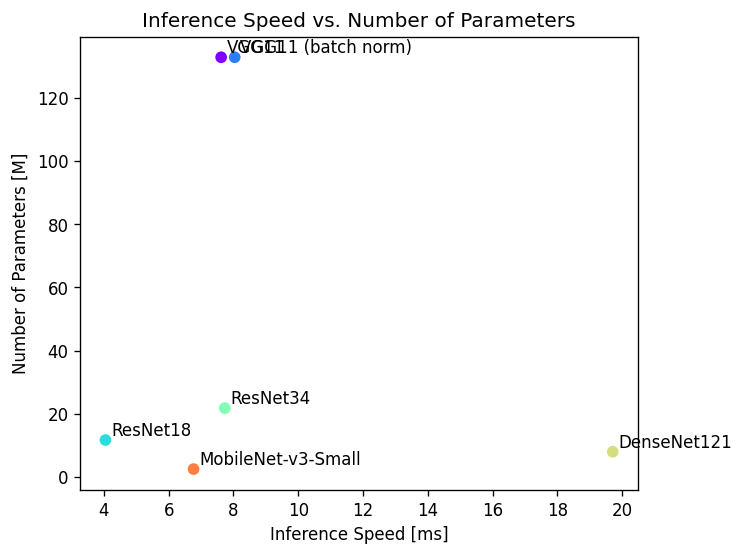

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)


cm = matplotlib.cm.rainbow(np.arange(len(model_names)) / len(model_names))
ax.scatter(model_inference_runtime, parameter_num_million, c=cm)

for i, model_name in enumerate(model_names):
  #ax.scatter(model_accuracies[i], model_inference_runtime[i], label=model_name)
  x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
  y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
  ax.annotate(model_name, (model_inference_runtime[i] + x_offset, parameter_num_million[i] + y_offset))

plt.title("Inference Speed vs. Number of Parameters")
ax.set_xlabel("Inference Speed [ms]")
ax.set_ylabel("Number of Parameters [M]")

plt.show()

# Exercise 1.1b)

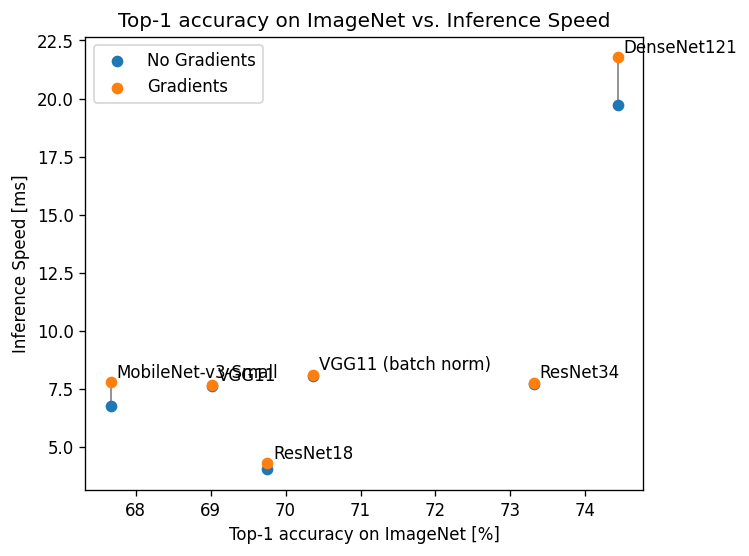

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)

ax.scatter(model_accuracies, model_inference_runtime, label="No Gradients")
ax.scatter(model_accuracies, model_inference_runtime_grads, label="Gradients")

for i, model_name in enumerate(model_names):
  #ax.scatter(model_accuracies[i], model_inference_runtime[i], label=model_name)
  ax.plot([model_accuracies[i]] * 2, [model_inference_runtime[i], model_inference_runtime_grads[i]], c="gray", zorder=-100, linewidth=1)
  x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
  y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
  #ax.annotate(model_name, (model_accuracies[i] + x_offset, model_inference_runtime[i] + y_offset))
  ax.annotate(model_name, (model_accuracies[i] + x_offset, model_inference_runtime_grads[i] + y_offset))

plt.title("Top-1 accuracy on ImageNet vs. Inference Speed")
ax.set_xlabel("Top-1 accuracy on ImageNet [%]")
ax.set_ylabel("Inference Speed [ms]")

plt.legend()

plt.show()

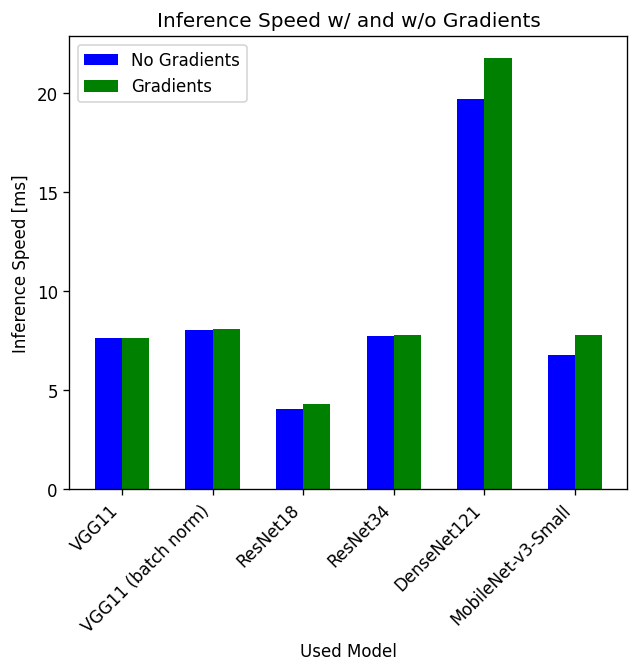

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)

x = np.arange(len(model_names))
ax.bar(x-0.15, model_inference_runtime, width=0.3, color='b', align='center', label="No Gradients")
ax.bar(x+0.15, model_inference_runtime_grads, width=0.3, color='g', align='center', label="Gradients")

plt.title("Inference Speed w/ and w/o Gradients")
ax.set_xlabel("Used Model")
plt.xticks(x, model_names, rotation=45, ha="right")
ax.set_ylabel("Inference Speed [ms]")

plt.legend()

plt.show()

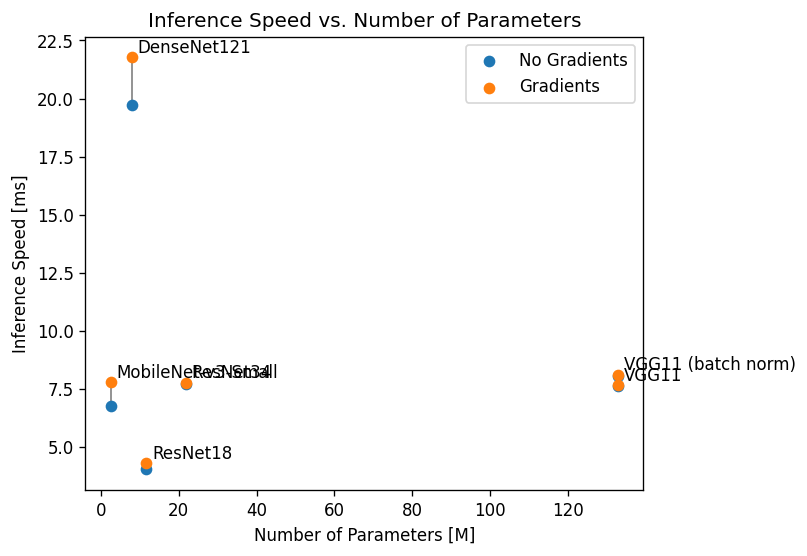

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)

ax.scatter(parameter_num_million, model_inference_runtime, label="No Gradients")
ax.scatter(parameter_num_million, model_inference_runtime_grads, label="Gradients")

for i, model_name in enumerate(model_names):
  ax.plot([parameter_num_million[i]] * 2, [model_inference_runtime[i], model_inference_runtime_grads[i]], c="gray", zorder=-100, linewidth=1)
  x_offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
  y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
  ax.annotate(model_name, (parameter_num_million[i] + x_offset, model_inference_runtime_grads[i] + y_offset))

plt.title("Inference Speed vs. Number of Parameters")
ax.set_xlabel("Number of Parameters [M]")
ax.set_ylabel("Inference Speed [ms]")
plt.legend()
plt.show()

# Exercise 1.1c)

In [13]:
num_iterations = 100
gpu_memory = []
gpu_memory_grads = []

#TODO does memory need to be cleared before measuring?

image_batch_size = (64, 3, 256,256)
image_batch = torch.rand(image_batch_size)
image_batch = image_batch.to(device)

[m.to("cpu") for m in models]

for idx, model in enumerate(models):
  model.to("cuda")
  torch.cuda.empty_cache()
  model.eval()
  gpu_mem = []
  start = time()
  # no grad version
  for iteration in range(num_iterations):
    with torch.no_grad():
      _ = model(image)
      model(image)
      if iteration > num_iterations * 0.1:
        gpu_mem.append(torch.cuda.memory_allocated())
  end = time()
  gpu_memory.append(np.mean(gpu_mem) / 1e6)
  print(f"Model {model_names[idx]} took had a mean GPU utilization of {round(np.mean(gpu_mem) / 1e6, 1)}MB")
  model.to("cpu")
  torch.cuda.empty_cache()


[m.to("cpu") for m in models]
torch.cuda.empty_cache()

for idx, model in enumerate(models):
  # grad version
  model.to("cuda")
  model.train()
  gpu_mem = []
  torch.cuda.empty_cache()
  for iteration in range(num_iterations):
    _ = model(image)
    #print(f"GPU Memory usage: {torch.cuda.memory_allocated()}")
    if iteration > num_iterations * 0.1:
      gpu_mem.append(torch.cuda.memory_allocated())
  end = time()
  gpu_memory_grads.append(np.mean(gpu_mem) / 1e6)
  print(f"Model {model_names[idx]} took had a mean GPU utilization of {round(np.mean(gpu_mem) / 1e6, 1)}MB (with gradients)")
  model.to("cpu")
  torch.cuda.empty_cache()


Model VGG11 took had a mean GPU utilization of 583.5MB
Model VGG11 (batch norm) took had a mean GPU utilization of 583.0MB
Model ResNet18 took had a mean GPU utilization of 98.0MB
Model ResNet34 took had a mean GPU utilization of 139.4MB
Model DenseNet121 took had a mean GPU utilization of 83.5MB
Model MobileNet-v3-Small took had a mean GPU utilization of 61.4MB
Model VGG11 took had a mean GPU utilization of 691.2MB (with gradients)
Model VGG11 (batch norm) took had a mean GPU utilization of 926.1MB (with gradients)
Model ResNet18 took had a mean GPU utilization of 232.8MB (with gradients)
Model ResNet34 took had a mean GPU utilization of 223.2MB (with gradients)
Model DenseNet121 took had a mean GPU utilization of 430.6MB (with gradients)
Model MobileNet-v3-Small took had a mean GPU utilization of 103.3MB (with gradients)


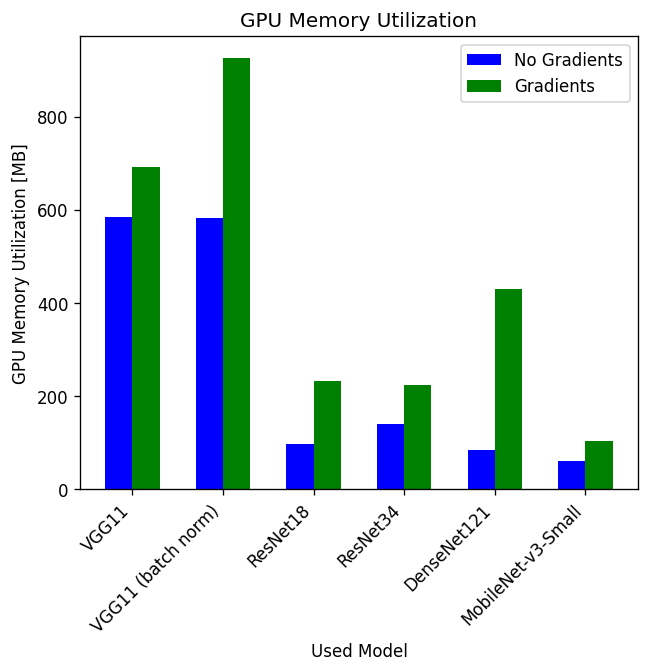

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)

x = np.arange(len(model_names))

ax.bar(x-0.15, gpu_memory, width=0.3, color='b', align='center', label="No Gradients")
ax.bar(x+0.15, gpu_memory_grads, width=0.3, color='g', align='center', label="Gradients")

plt.title("GPU Memory Utilization")
ax.set_xlabel("Used Model")
plt.xticks(x, model_names, rotation=45, ha="right")
ax.set_ylabel("GPU Memory Utilization [MB]")

plt.legend()
plt.show()

# 1.2a) Accuracy Plot

In [15]:
validation_accuracies = [0.5386, 0.5644, 0.5754, 0.5844, 0.5798, 0.583, 0.5874, 0.5892, 0.592, 0.589, 0.595, 0.5906, 0.5832, 0.5862, 0.5906, 0.5886]
epochs = list(range(1,len(validation_accuracies)+1))
test_accuracy = 0.586 #TODO replace with real values

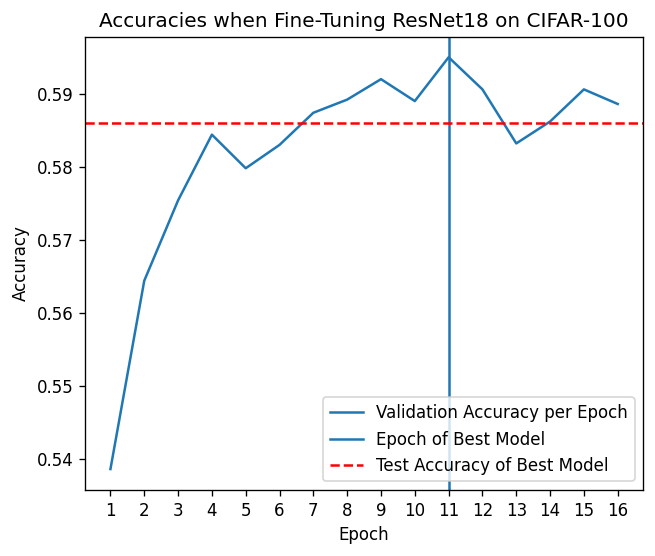

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=120)
ax.plot(epochs, validation_accuracies, label="Validation Accuracy per Epoch")
ax.axvline(x = np.argmax(validation_accuracies) + 1, linestyle = '-', label="Epoch of Best Model")
ax.axhline(y = test_accuracy, color = 'r', linestyle = '--', label="Test Accuracy of Best Model")
ax.legend()
ax.set_xticks(epochs)
plt.title("Accuracies when Fine-Tuning ResNet18 on CIFAR-100")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()